#### Imports

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

movies = pd.read_csv('./dataset/movies.csv')

/Users/biboy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Preprocessing

In [6]:
movies.dropna(inplace=True, subset=['description'])

custom_stop_words = {'lives', 'life', 'director', 'directed', 'film', 'films', 'filmaker',}
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Tokenizing descriptions for dictionary
tokenized_descriptions = [doc.split() for doc in movies['description']]

# Remove stop words and vectorize to bag of words
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(movies['description'])
vocab = vectorizer.get_feature_names_out()

# Convert sparse matrix to Gensim's corpus
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary(tokenized_descriptions)

# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)

##### Determining Range of Topics for LDA using Log Likelihoods

Starting LDA 5
Model insantiated
Model fitted
LDA 5 : -31840565.051642843
Starting LDA 6
Model insantiated
Model fitted
LDA 6 : -32040022.425587997
Starting LDA 7
Model insantiated
Model fitted
LDA 7 : -32223829.665310863
Starting LDA 8
Model insantiated
Model fitted
LDA 8 : -32378227.133421343
Starting LDA 9
Model insantiated
Model fitted
LDA 9 : -32578166.388856735
Starting LDA 10
Model insantiated
Model fitted
LDA 10 : -32738975.35767676
Starting LDA 11
Model insantiated
Model fitted
LDA 11 : -32925078.380780444
Starting LDA 12
Model insantiated
Model fitted
LDA 12 : -33050921.995269623
Starting LDA 13
Model insantiated
Model fitted
LDA 13 : -33198237.37267091
Starting LDA 14
Model insantiated
Model fitted
LDA 14 : -33311486.95228181
Starting LDA 15
Model insantiated
Model fitted
LDA 15 : -33419940.958567064
Starting LDA 16
Model insantiated
Model fitted
LDA 16 : -33571876.10877669
Starting LDA 17
Model insantiated
Model fitted
LDA 17 : -33645197.05764979
Starting LDA 18
Model insan

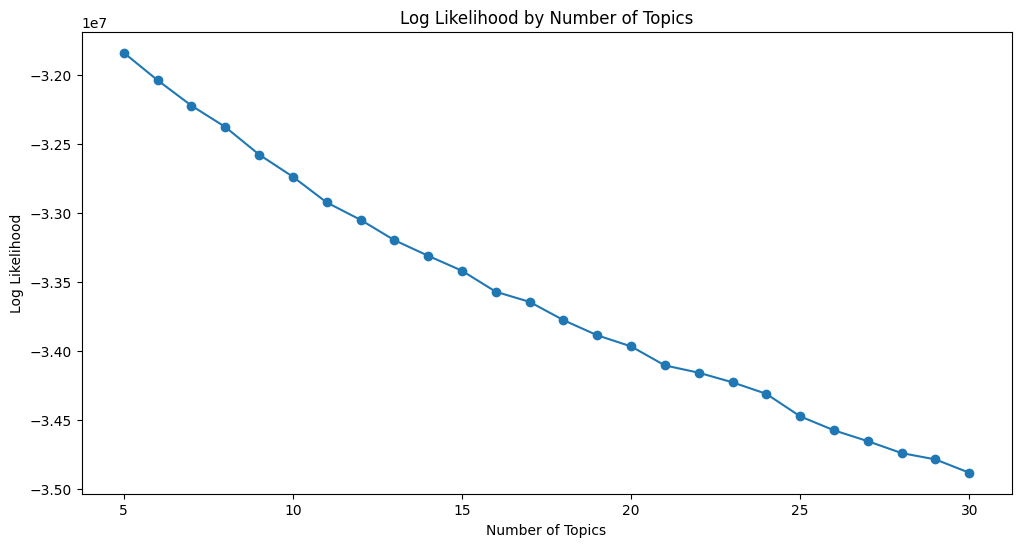

In [3]:
# log_likelihoods = []
# n_topics_options = range(5, 31)  # Trying from 5 to 30 topics
# for n_topics in n_topics_options:
#     print("Starting LDA", n_topics)
#     lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
#     print("Model insantiated")
#     lda.fit(X_normalized)
#     print("Model fitted")
#     ldaScore = lda.score(X_normalized)
#     log_likelihoods.append(ldaScore)
#     print("LDA", n_topics, ":", ldaScore)

# # Plot log likelihoods
# plt.figure(figsize=(12, 6))
# plt.plot(n_topics_options, log_likelihoods, marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Log Likelihood')
# plt.title('Log Likelihood by Number of Topics')
# plt.show()

##### Determining Model with highest Coherence score from range of Topics

In [ ]:
selected_range = range(2,6)  # Selecting a range based on the log likelihood plot (TBD)
coherence_scores = []
models = []
for n_topics in selected_range:
    print("Starting", n_topics)
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, passes=10, random_state=0)
    print("Model instantiated")
    models.append(lda_model)
    
    # Calculate coherence score
    cm = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=id2word, coherence='c_v')
    coherence = cm.get_coherence()
    print("LDA", n_topics, ":", coherence)
    coherence_scores.append(coherence)

    # Print top words per topic
    n_top_words = 15

    def print_top_words(model, n_top_words):
        for idx, topic in model.print_topics(-1):
            print(f"Topic #{idx}: {topic}")

    print("Top words per topic:")
    print_top_words(lda_model, n_top_words)


# Plot coherence scores
plt.figure(figsize=(12, 6))
plt.plot(list(selected_range), coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence by Number of Topics')
plt.show()

# Select the model with the highest coherence score
best_topic_n = selected_range[np.argmax(coherence_scores)]
best_lda_model = models[np.argmax(coherence_scores)]
lda_transformed = best_lda_model.get_document_topics(corpus, minimum_probability=0)

#### Fitting to K-means Model and Determining Optimal Clusters

In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(lda_transformed)
    score = silhouette_score(lda_transformed, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Select the optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans_final.fit(lda_transformed)

#### Results and Plots

In [ ]:
movies['Cluster'] = kmeans_final.labels_

# Plot clusters
plt.figure(figsize=(10, 5))
plt.hist(movies['Cluster'], bins=optimal_clusters, alpha=0.7, rwidth=0.85)
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies Across Clusters')
plt.xticks(range(optimal_clusters))
plt.show()